# Prepare
Imports and loading data

In [1]:
from tint.datasets import HMM
from matplotlib import pyplot as plt
import pickle as pkl
import os
import numpy as np

In [2]:
# Define identical HMM definition as in the experiment
# This will load the generated HMM data instead of re-generating the files (which take a long time)
hmm = HMM(n_folds=5, fold=0, seed=42)

In [3]:
# Get train and test input and output (x and y)
test_data = hmm.preprocess("test")
x, y = test_data["x"].numpy(), test_data["y"].numpy()
true_saliency = hmm.true_saliency(split="test").numpy()

In [4]:
# Get test predictions from the classifier (y_hat)
with open(
    os.path.join(hmm.data_dir, "classifier_predictions_test.npz"), "rb"
) as fp:
    y_hat = pkl.load(file=fp).detach().numpy()
    
y_hat.shape

(200, 200)

In [5]:
# Get saved explanations by all explainers
with open(
    os.path.join(hmm.data_dir, "explanations.npz"), "rb"
) as fp:
    explanations = pkl.load(file=fp)

print(explanations.keys())
print(explanations[list(explanations.keys())[0]].shape)

dict_keys(['extremal_mask', 'extremal_mask_deletion'])
torch.Size([200, 200, 3])


# Plots

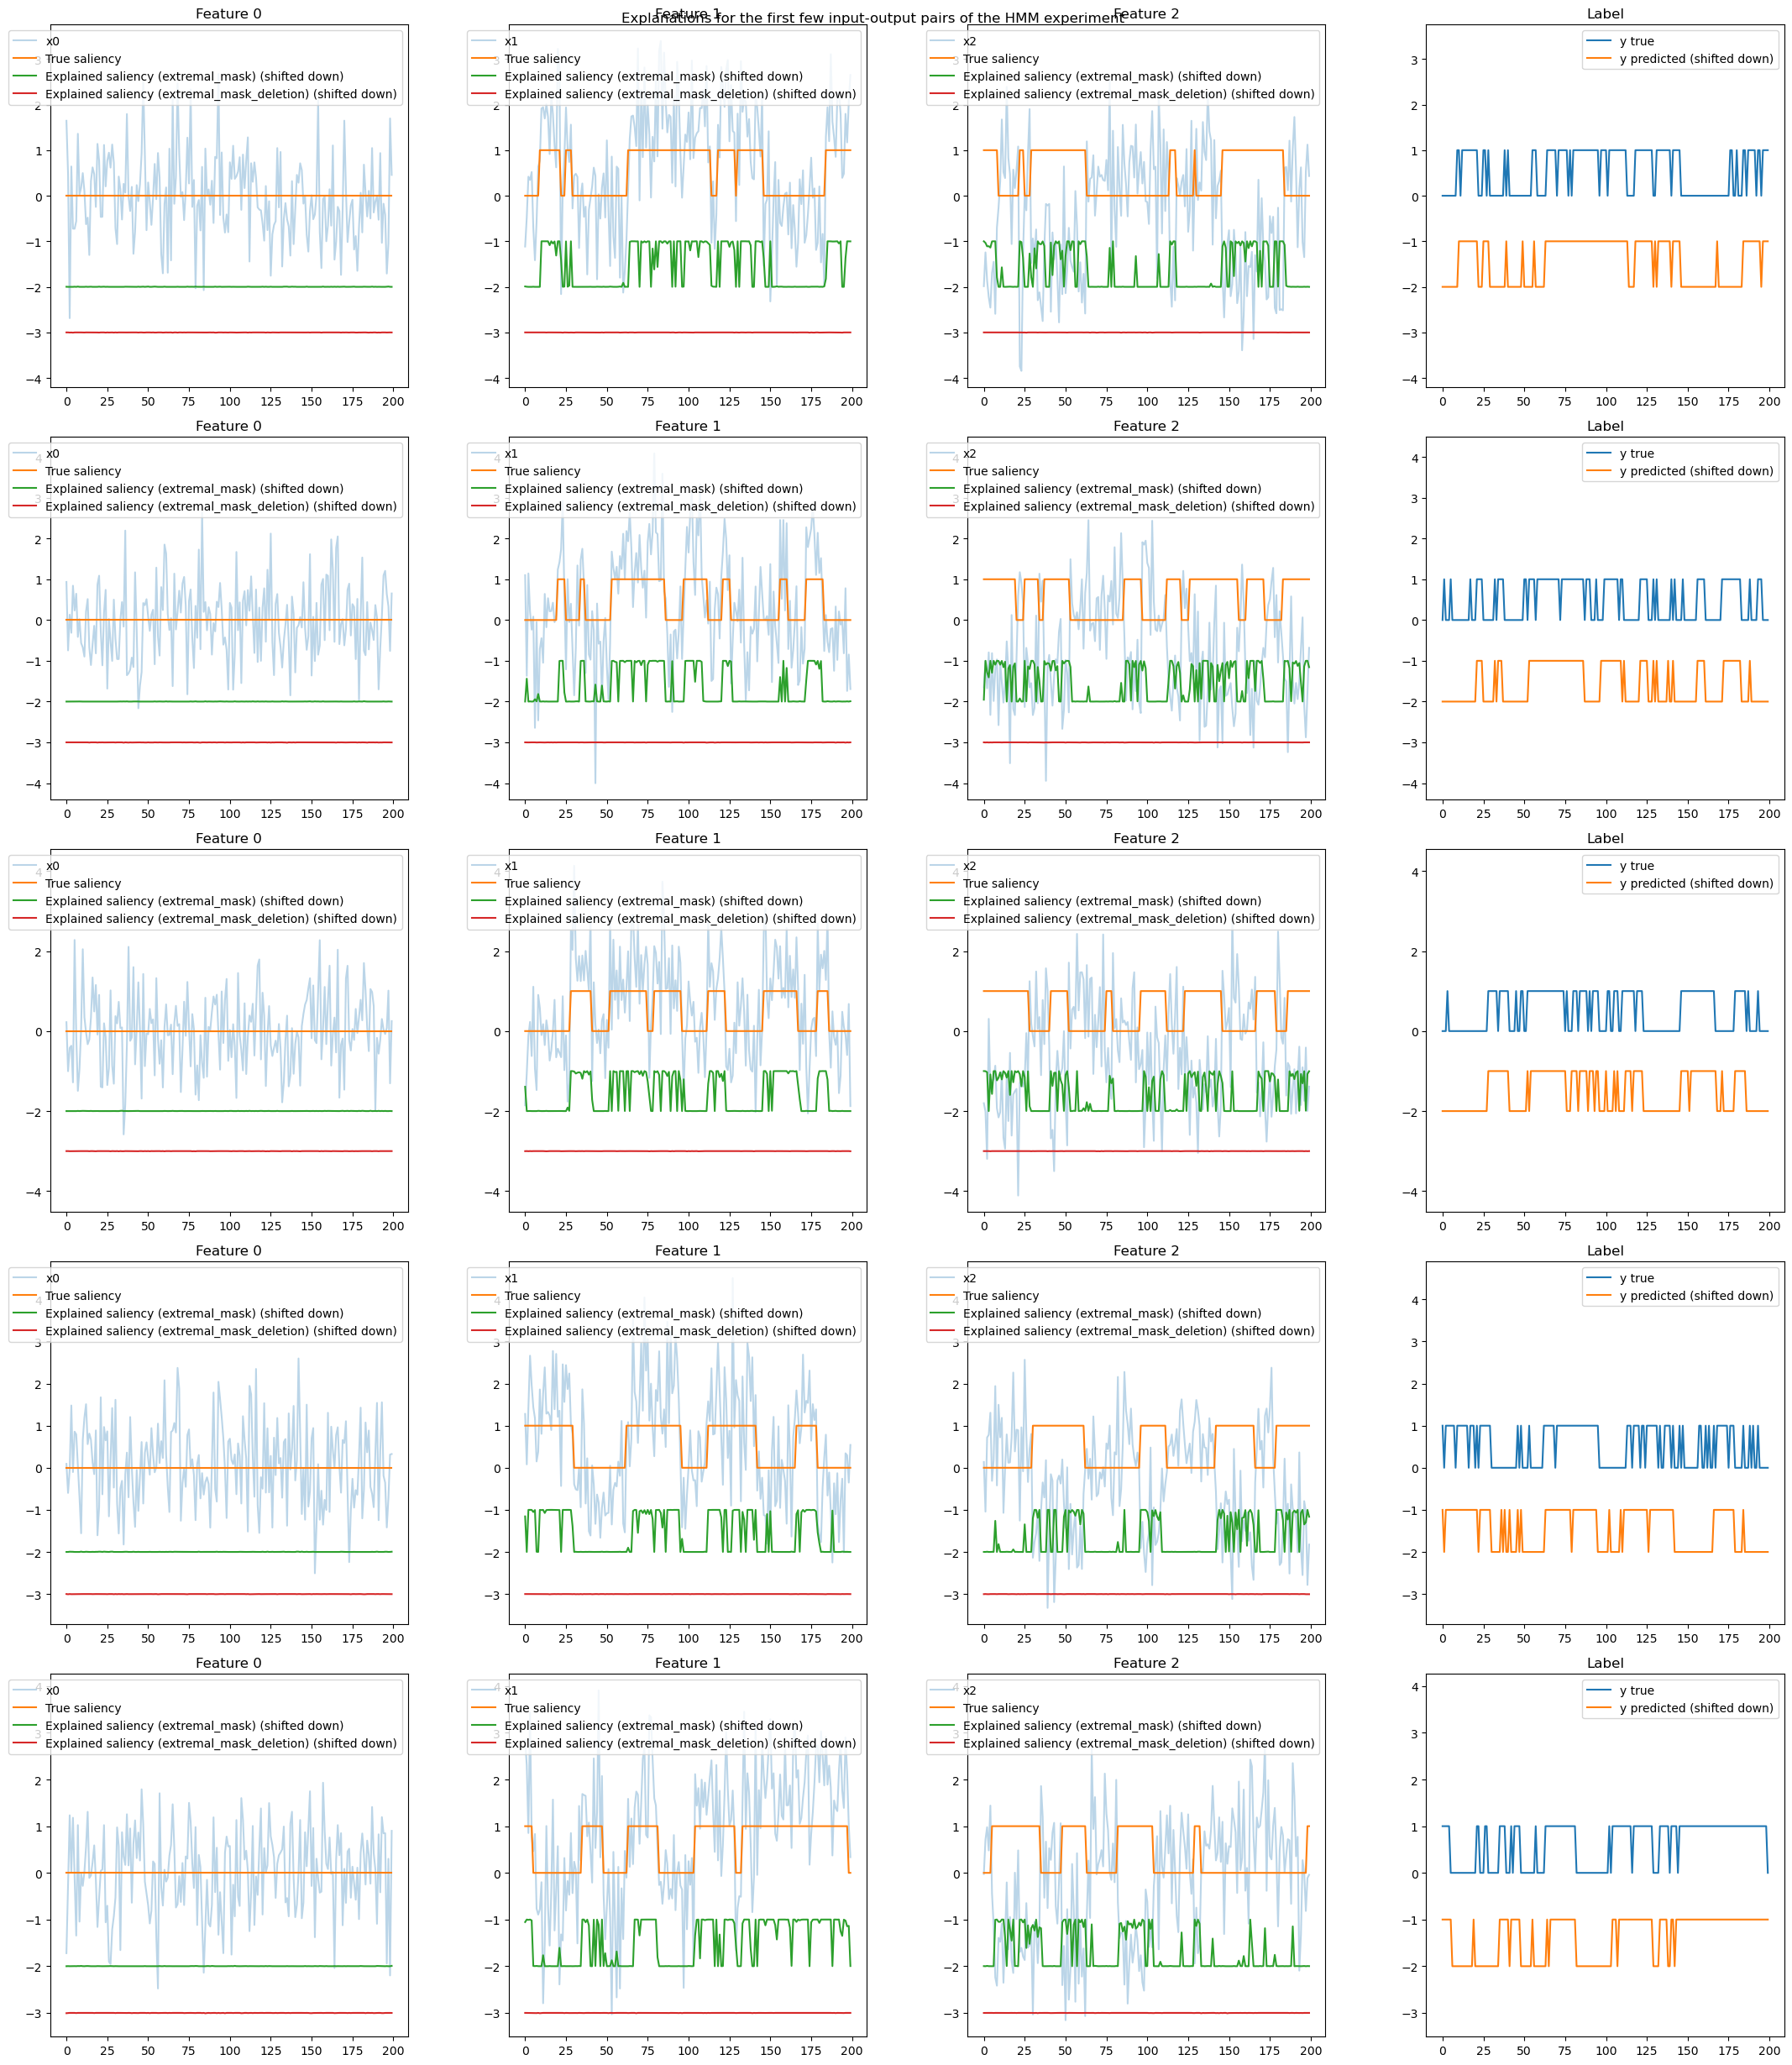

In [6]:
# Generate debug plots
patients_to_plot = 5  # this is HMM, so there are no patients right now, but this is still the clearest name imho

fig = plt.figure(figsize=(22, 5 * patients_to_plot))
fig.suptitle("Explanations for the first few input-output pairs of the HMM experiment")
plot_id = 1
for row in range(patients_to_plot):
    base_ax = None
    # Plot each input feature x
    for feature_id in range(0, 3):
        ax = plt.subplot(patients_to_plot, 4, plot_id, sharex=base_ax, sharey=base_ax)
        ax.set_title(f"Feature {feature_id}")
        if not base_ax:
            base_ax = ax

        ax.plot(x[row, :, feature_id], label=f"x{feature_id}", alpha=0.3)
        ax.plot(true_saliency[row, :, feature_id], label="True saliency")
        
        for i, (explanation_method, explanation_values) in enumerate(explanations.items()):
            ax.plot(explanation_values[row, :, feature_id] - i*2 - 2, label=f"Explained saliency ({explanation_method}) (shifted down)")
        ax.legend()
        plot_id += 1
    
    # Plot output (y and y_hat)
    ax = plt.subplot(patients_to_plot, 4, plot_id, sharex=base_ax, sharey=base_ax)
    ax.set_title(f"Label")
    ax.plot(y[row], label=f"y true")
    ax.plot(y_hat[row] - 2, label=f"y predicted (shifted down)")
    # ax.plot(x[row, :, 1] - x[row, :, 2] -5, label=f"Diff between x1 and x2")
    # ax.plot([-5] * 200, label=f"Diff center")
    ax.legend()
    plot_id += 1
plt.tight_layout()
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/explorations.png")

In [17]:
# Create a histogram for the saliency. In the HMM data set we have 3 input features, and in each time
# step only one of them is important, so we expect k ones and 2*k zeros. This is exactly what we see.
# For some reason the hist function does not work on my computer for this data, I assume it might be
# due to an old mpl/Python version? I didn't debug it, just calculated the values directly, as we only
# have ones and zeros here.
# plt.hist(true_saliency.reshape((1, -1)))
values, counts = np.unique(true_saliency, return_counts=True)
print(f"Count of values {values}: {counts}")


Count of values [0 1]: [80000 40000]


Text(0.5, 1.0, "Histogram of explained importance values for 'extremal mask (preservation)'")

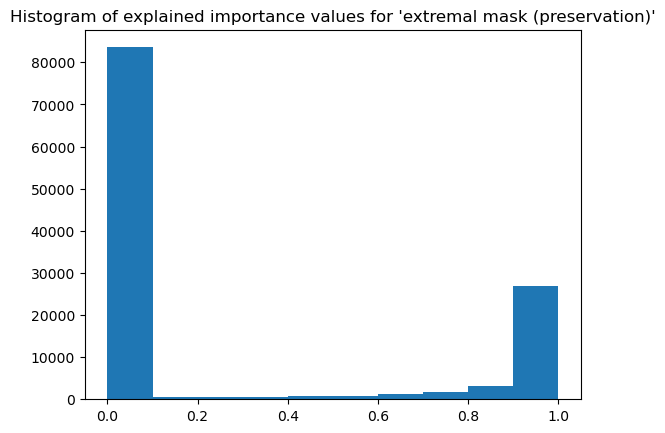

In [20]:
# Show the histogram of values for the preservation game. That looks reasonable
plt.hist(explanations["extremal_mask"].reshape((1, -1)))
plt.xlim((-0.05, 1.05))
plt.title(f"Histogram of explained importance values for 'extremal mask (preservation)'")

Text(0.5, 1.0, "Histogram of explained importance values for 'extremal mask (deletion)'")

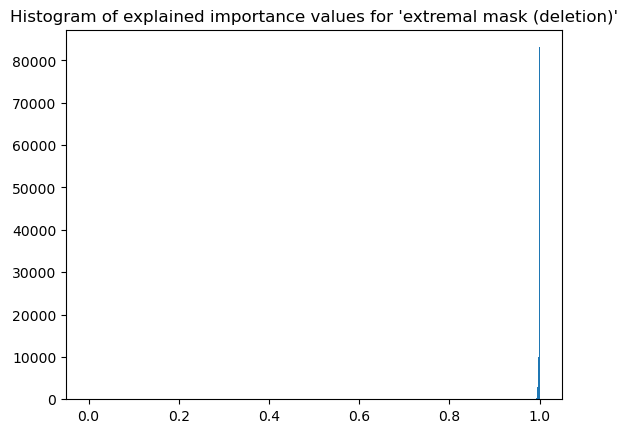

In [24]:
# Show the histogram of values for the preservation game
# That is horribly skewed and zeros are completely missing
plt.hist(explanations["extremal_mask_deletion"].reshape((1, -1)))
plt.xlim((-0.05, 1.05))
plt.title(f"Histogram of explained importance values for 'extremal mask (deletion)'")